In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import seaborn as sns
from pybiomart import Dataset
import scanpy as sc
import anndata as ad
from sklearn import linear_model
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from dadapy.data import Data
from scipy.stats import rankdata
from scipy.stats import pearsonr
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import importlib
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

random.seed(42)

c:\Users\marta\Documents\SC_myEnv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''RAW_DATA = sc.read_h5ad('gastrulating_human_embryo.h5ad')
del RAW_DATA.obs['X0']
del RAW_DATA.obs['X1']
del RAW_DATA.obs['sub_cluster']
del RAW_DATA.obs['cell_name']
RAW_DATA.obs['celltype']=RAW_DATA.obs['cluster_id'].copy()
del RAW_DATA.obs['cluster_id']
RAW_DATA.write_h5ad('HumanGastrulation_formatted.h5ad',compression='gzip')'''

"RAW_DATA = sc.read_h5ad('gastrulating_human_embryo.h5ad')\ndel RAW_DATA.obs['X0']\ndel RAW_DATA.obs['X1']\ndel RAW_DATA.obs['sub_cluster']\ndel RAW_DATA.obs['cell_name']\nRAW_DATA.obs['celltype']=RAW_DATA.obs['cluster_id'].copy()\ndel RAW_DATA.obs['cluster_id']\nRAW_DATA.write_h5ad('HumanGastrulation_formatted.h5ad',compression='gzip')"

In [3]:
my_ct_sorted    = [ 'Epiblast','Primitive Streak',

                    # ectoderm lineage:
                    #'Non-Neural Ectoderm',

                    # endoderm lineage:
                    'Endoderm', 
                    
                    # mesoderm lineage:
                    #'ExE Mesoderm', 'Axial Mesoderm',
                    'Nascent Mesoderm',
                    'Emergent Mesoderm',
                    'Advanced Mesoderm',
                    'Hemogenic Endothelial Progenitors',
                    #'Erythroblasts'
                    ]

In [4]:
%%time
#adata = sc.read_h5ad('Data/HumanGastrulation_formatted.h5ad')
adata = sc.read_h5ad('HumanGastrulation_formatted.h5ad')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata=adata[adata.obs['celltype'].isin(my_ct_sorted)].copy()
adata.obs = adata.obs.reset_index(drop=True)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15,method='umap')
sc.tl.diffmap(adata, n_comps=15)
sc.tl.umap(adata)

CPU times: total: 12.2 s
Wall time: 8.44 s


In [5]:
%%time
RAW_DATA = sc.read_h5ad('HumanGastrulation_formatted.h5ad')
RAW_DATA_selected_ct=RAW_DATA[RAW_DATA.obs['celltype'].isin(my_ct_sorted)].copy()
RAW_DATA_selected_ct.obs = RAW_DATA_selected_ct.obs.reset_index(drop=True)
dataset = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')
protein_coding_genes = dataset.query(
    attributes=[
        'ensembl_gene_id',        # Ensembl Gene ID
        'external_gene_name',     # Gene Name
        'gene_biotype'            # Biotype (to filter for protein-coding)
    ]
)
protein_coding_genes = protein_coding_genes[protein_coding_genes['Gene type'] == 'protein_coding']
DATA_protein_coding=RAW_DATA_selected_ct[:,list(set(protein_coding_genes['Gene name'])&set(RAW_DATA.var.index))].copy()
sc.pp.normalize_total(DATA_protein_coding)
DATA_protein_coding

CPU times: total: 1.48 s
Wall time: 6.28 s


AnnData object with n_obs × n_vars = 1028 × 18500
    obs: 'celltype'

In [6]:
%%time

neighbors = NearestNeighbors(n_neighbors=70)

# neighbors: entire diffusion map embedding (15 components)
#data_matrix = adata.obsm["X_diffmap"].copy()

# neighbors: 2-dim diffusion map embedding (DC1 and DC2)
data_matrix = adata.obsm["X_diffmap"][:,1:3].copy()

neighbors.fit(data_matrix)


nb_of_subsampling=10
nb_of_neighbors_for_id_estimation=50
CELLS=DATA_protein_coding.obs_names
ID_CELLS_mean=[]
ID_CELLS_std=[]

DISTANCES, INDICES = neighbors.kneighbors(data_matrix)

for cell in tqdm(CELLS):
    indices = INDICES[int(cell)]
    indices = indices.flatten()[1:]
    id_mycell=[]
    for i in range(nb_of_subsampling):
        np.random.shuffle(indices)
        cell_names=indices[:nb_of_neighbors_for_id_estimation]
        data_norm = Data(DATA_protein_coding[cell_names].X)
        data_norm.compute_id_2NN(mu_fraction = 0.9)
        myID=data_norm.intrinsic_dim
        id_mycell.append(myID)
    ID_CELLS_mean.append(np.mean(id_mycell))
    ID_CELLS_std.append(np.std(id_mycell))

100%|██████████| 1028/1028 [04:19<00:00,  3.97it/s]

CPU times: total: 42min 54s
Wall time: 4min 19s


In [7]:
%%time
adata.obs['ID_local_std']=ID_CELLS_std
adata.obs['ID_local']=ID_CELLS_mean
root_ixs=adata.obs.sort_values(by='ID_local',ascending=False).index[0]
print(root_ixs)
adata.uns["iroot"] = root_ixs

sc.tl.dpt(adata, n_dcs=15)
adata.obs['dpt_pseudotime'] = adata.obs['dpt_pseudotime'].astype(float)

578
CPU times: total: 156 ms
Wall time: 3.55 ms


In [8]:
my_colors   = [ cm.get_cmap('tab20')(0),
                cm.get_cmap('tab20')(1),
                #cm.get_cmap('cool')(0), 
                cm.get_cmap('tab20')(2),
                #cm.get_cmap('winter')(.999),
                #cm.get_cmap('winter')(0),   
                cm.get_cmap('tab20c')(8),
                cm.get_cmap('tab20c')(10),
                cm.get_cmap('Set2')(0),
                cm.get_cmap('tab20')(6),
                #cm.get_cmap('cool')(.999)  
                ]

my_markers  = [ 'o','d',
                #'.',
                '>', 
                #'.','.',
                's', 'p', 'v','*',#'.'
                ]


plot_params = {
    "label_size": 43,
    "markersize": 22,
    "linewidth": 5,
    "alpha": 0.6,
    "markeredgewidth": 5,
    "ticks_length": 2,
    "ticks_width": 0.5,
    "legend_fraction": 0.73,
}

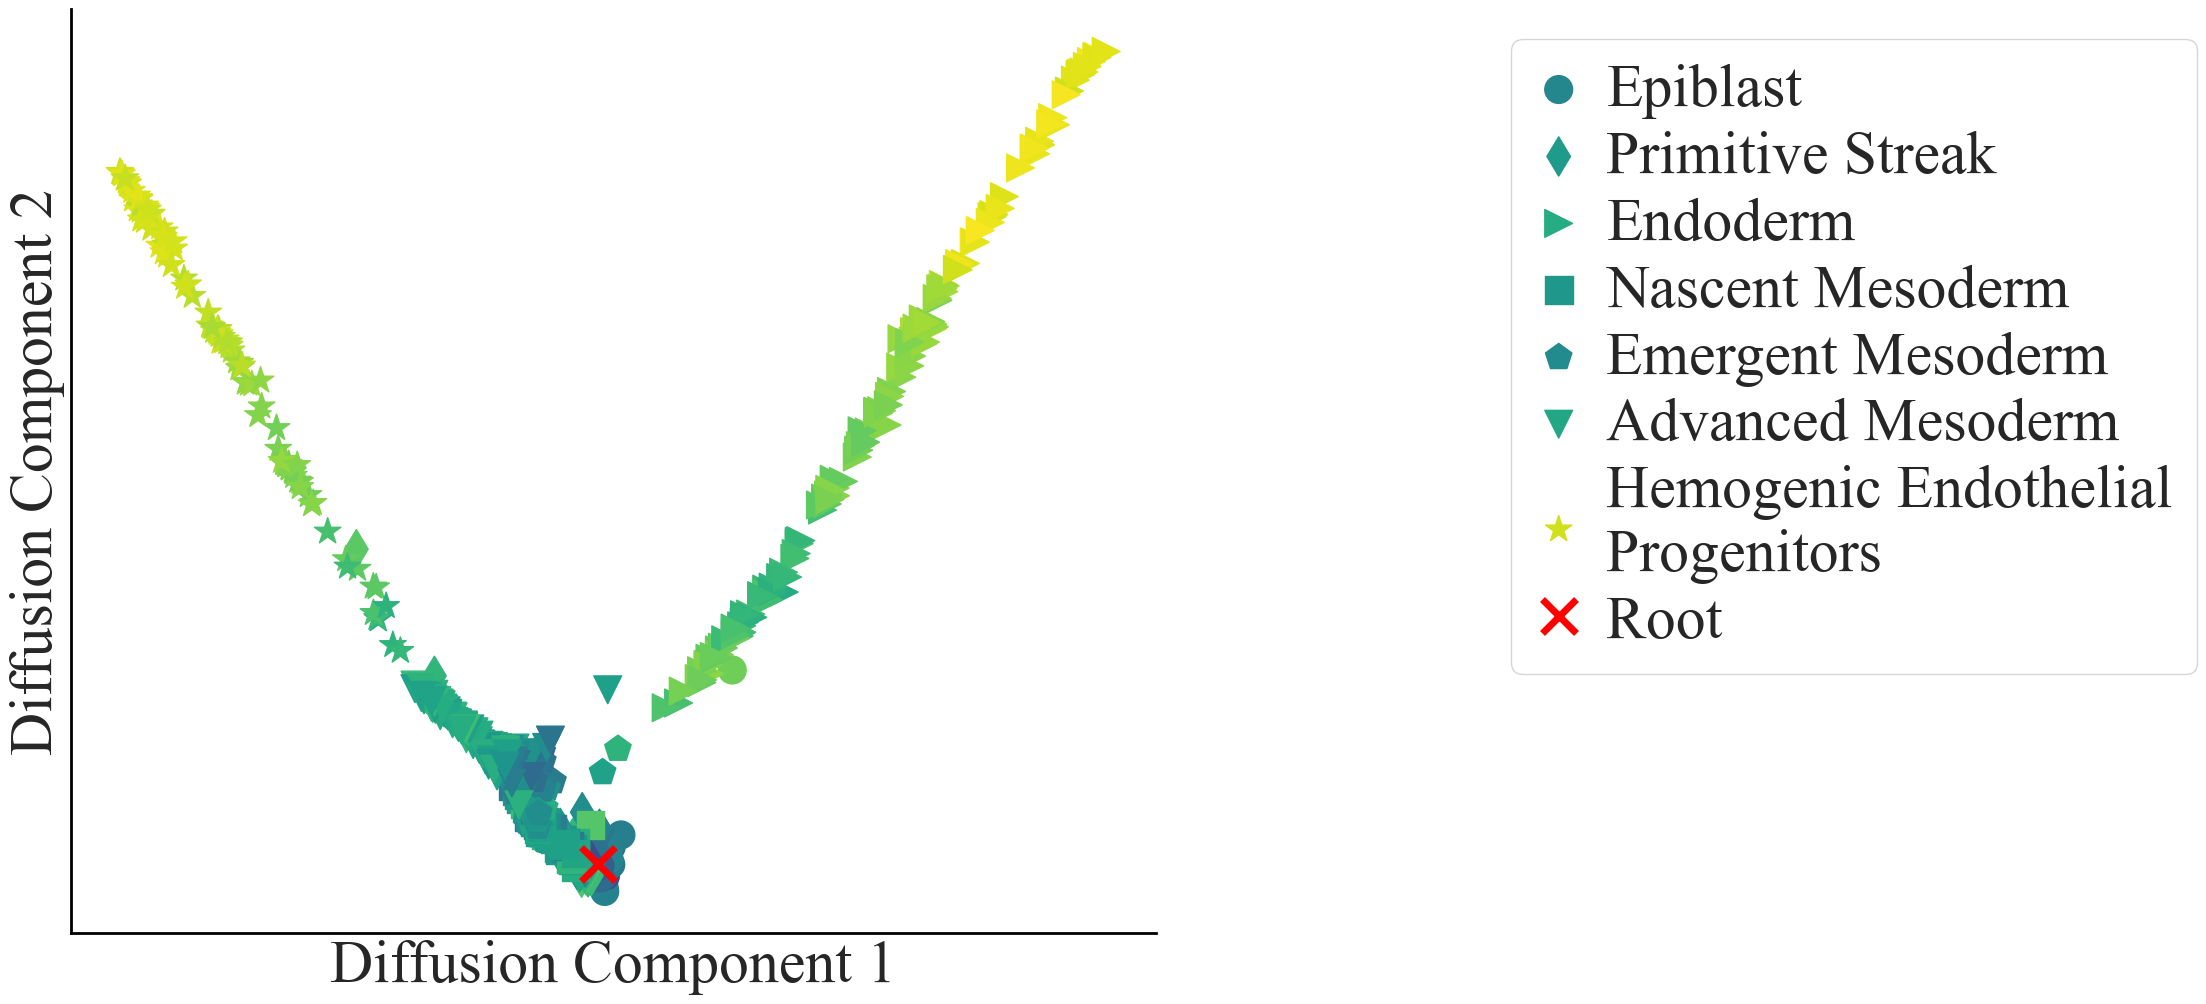

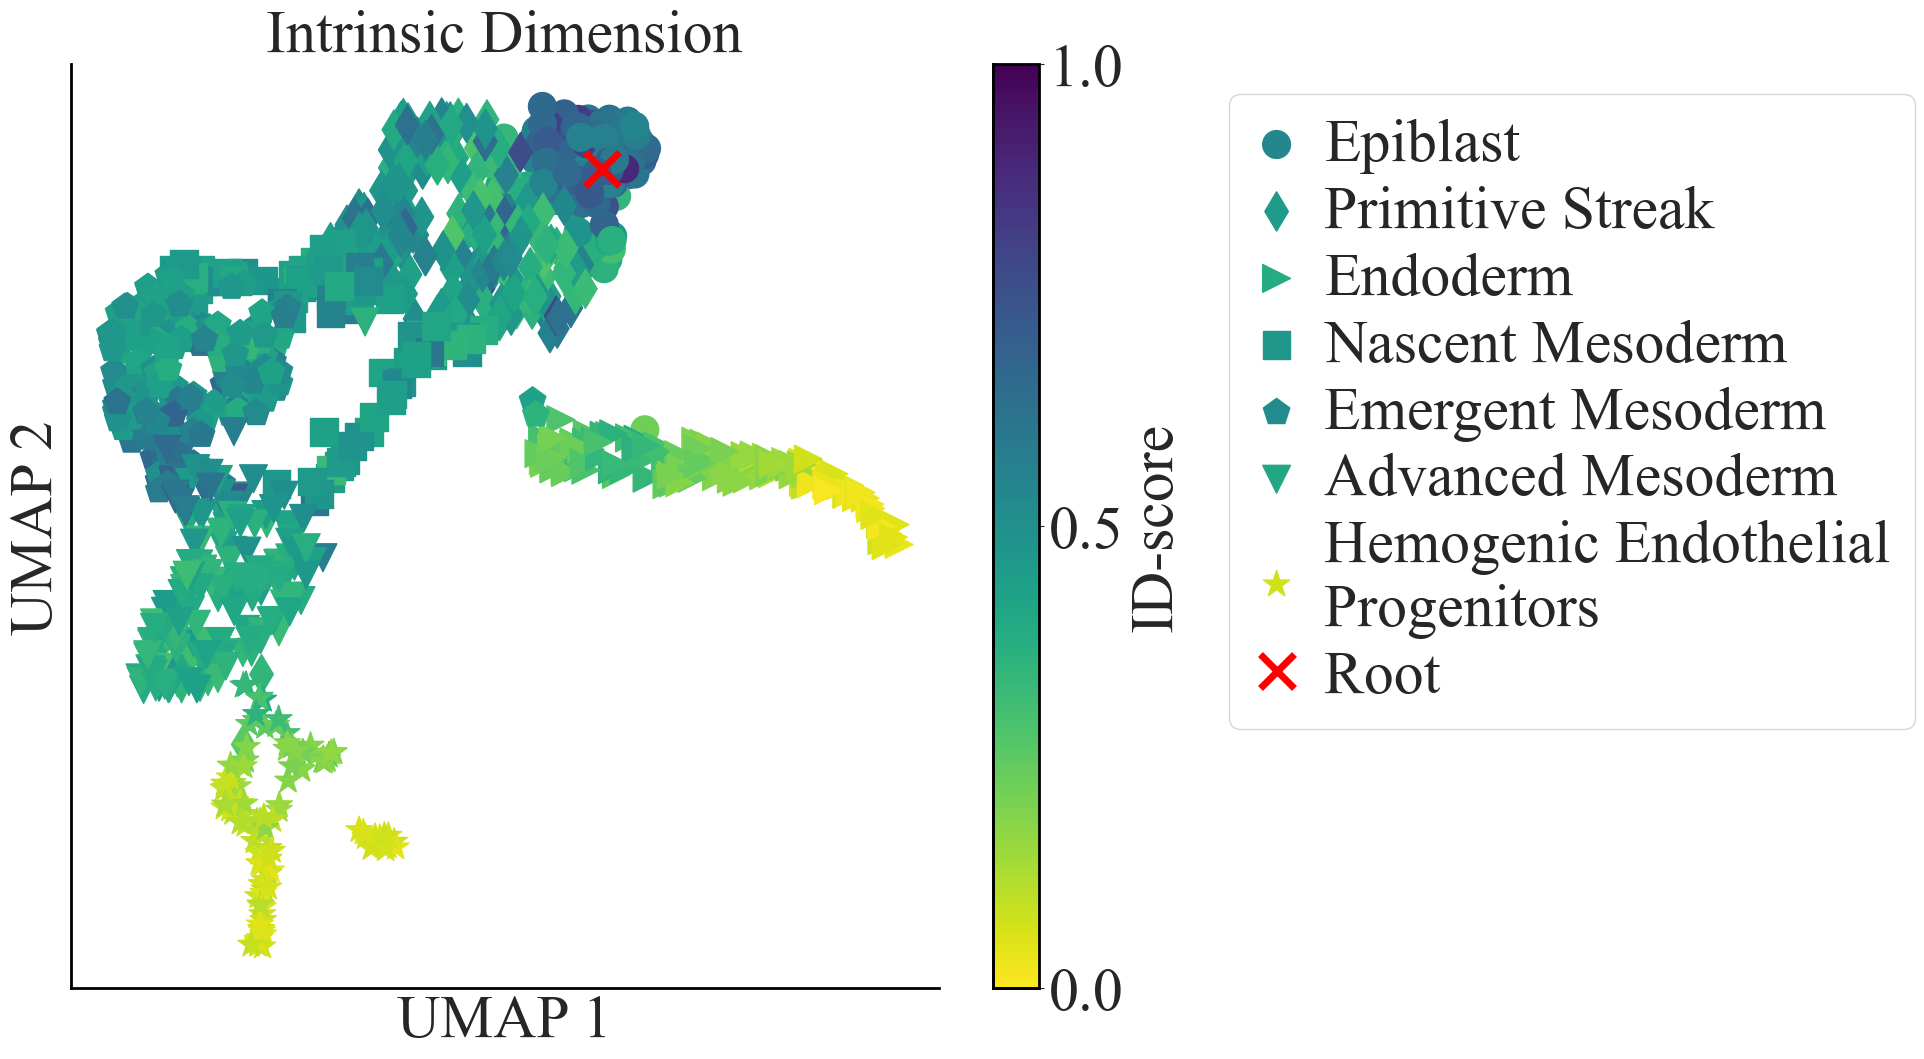

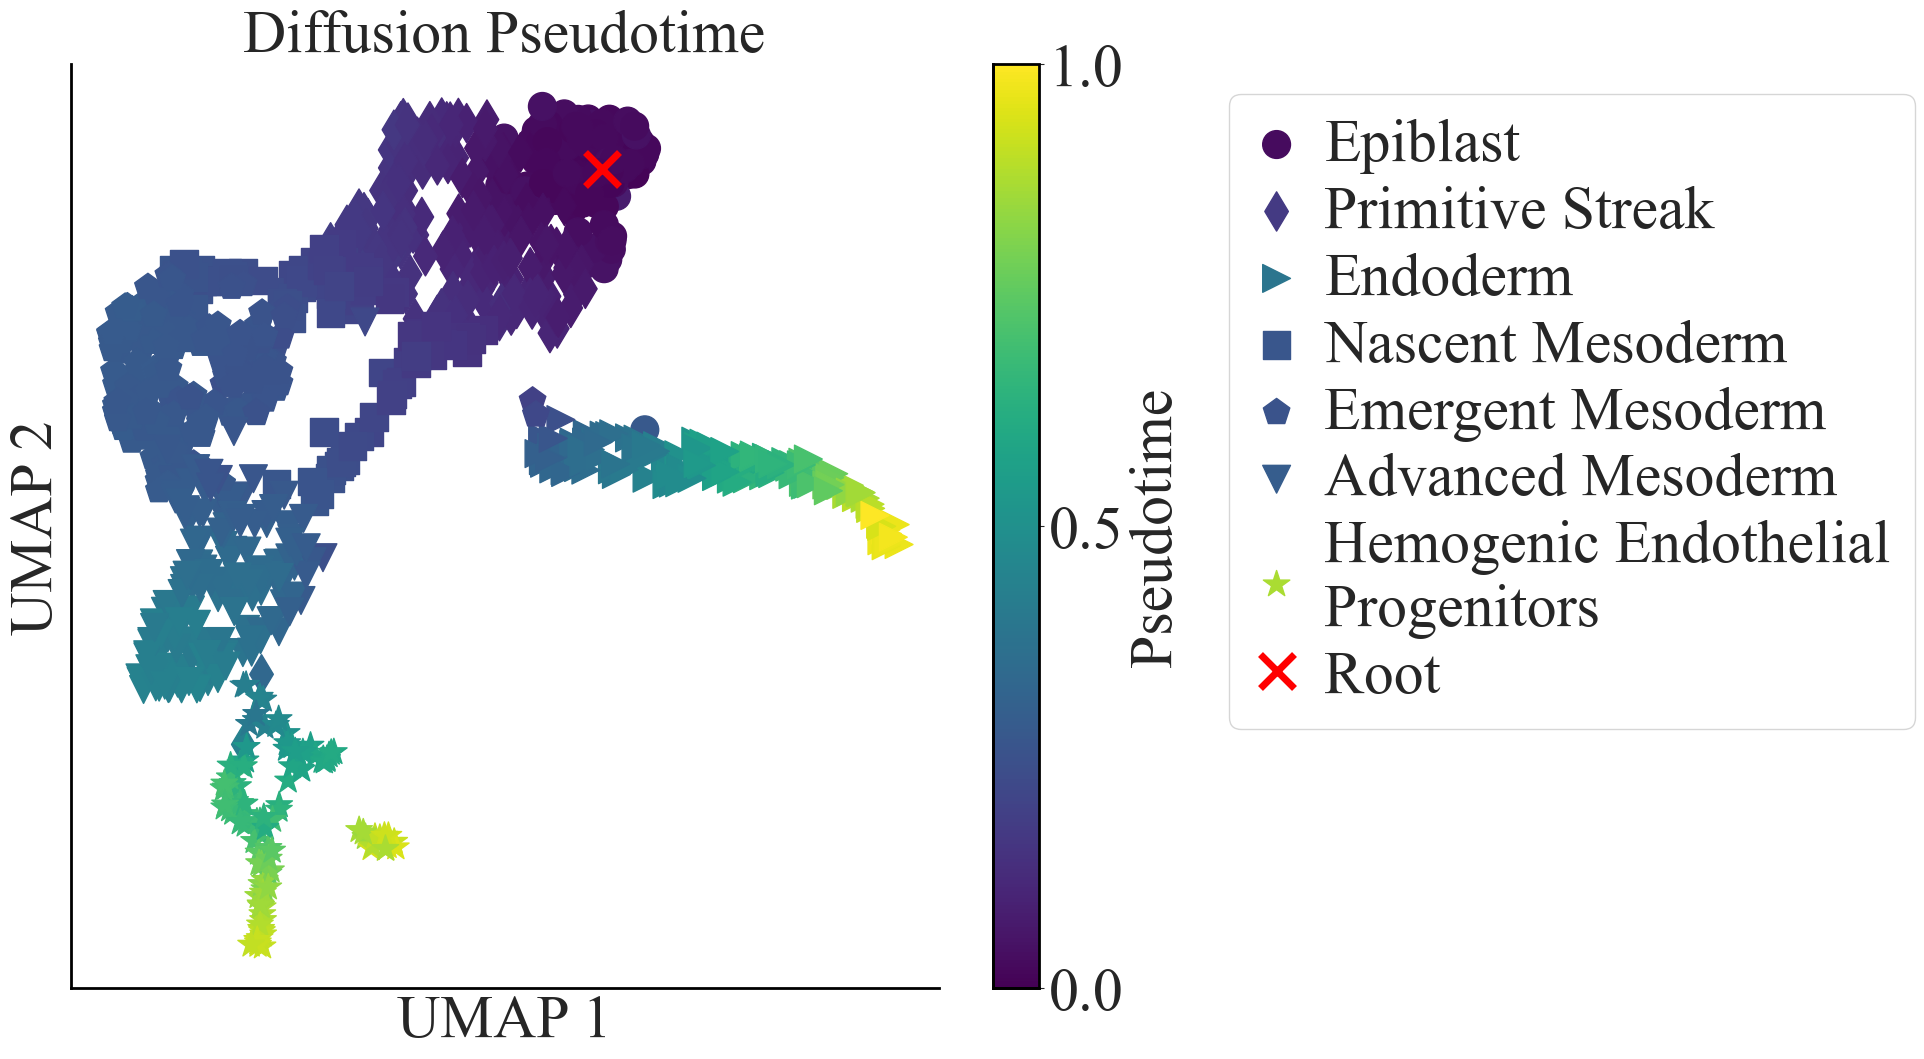

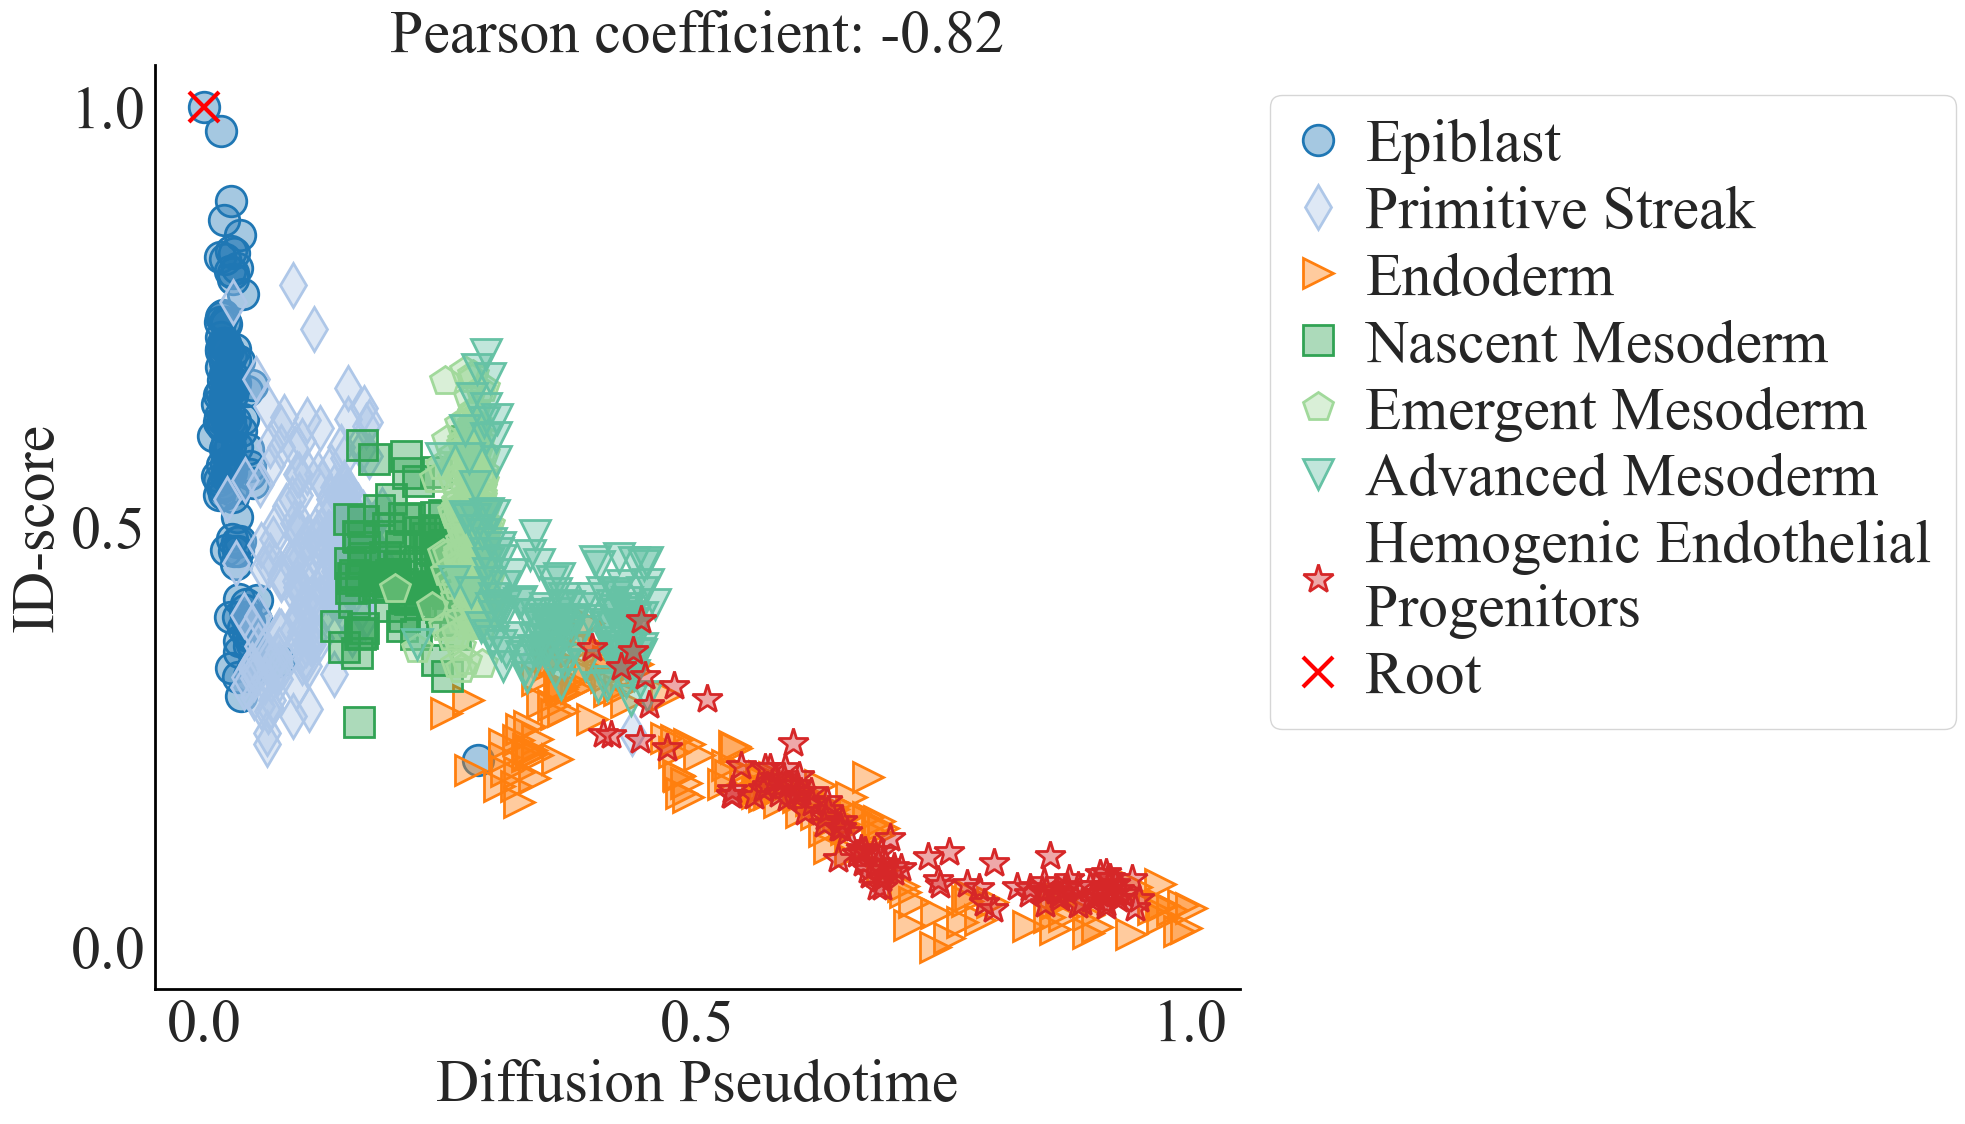

In [10]:
sns.set_style("white")

# Set matplotlib global style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'] + plt.rcParams['font.serif'],
    'axes.linewidth': 2,
    'axes.edgecolor': 'k',
})

# ==================================
# Helper Functions
# ==================================

def format_cluster_label(label):
    label=label.replace('ExE Mesoderm','Extra Embryonic\nMesoderm')
    label=label.replace('Hemogenic Endothelial Progenitors', 'Hemogenic Endothelial\nProgenitors')
    return label

def remove_axes_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ['top', 'bottom', 'left', 'right']:
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color('k')
    sns.despine()

def plot_root_points(ax, X, Y, label='Root'):
    ax.plot(X, Y, ls='None', marker='x', alpha=1, ms=25, c='r', mew=5, label=label)

def prepare_color_column(adata, source_column, cmap_name='viridis_r'):
    cmap = cm.get_cmap(cmap_name)
    values = adata.obs[source_column].values
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    colors = cmap(norm(values))
    adata.obs[f'{source_column}_color'] = list(colors)
    return cmap, norm

# ==================================
# Plot 1: Diffusion Map (Colored by ID-score)
# ==================================
fig, ax = plt.subplots(figsize=(14, 12))
_, _ = prepare_color_column(adata, 'ID_local')

for i, ct in enumerate(my_ct_sorted):
    subset = adata[adata.obs['celltype'] == ct]
    ax.scatter(subset.obsm['X_diffmap'][:, 1], subset.obsm['X_diffmap'][:, 2],
               c=subset.obs['ID_local_color'], marker=my_markers[i], s=400,
               label=format_cluster_label(ct), alpha=1)

plot_root_points(ax, adata.obsm['X_diffmap'][root_ixs, 1], adata.obsm['X_diffmap'][root_ixs, 2])
ax.set_xlabel('Diffusion Component 1', fontsize=plot_params['label_size'])
ax.set_ylabel('Diffusion Component 2', fontsize=plot_params['label_size'])
remove_axes_ticks(ax)
ax.legend(bbox_to_anchor=(1.3, 1), fontsize=plot_params['label_size'], handlelength=.8, handletextpad=.4, labelspacing=.2)
plt.show()

# ==================================
# Plot 2: UMAP (Colored by ID-score)
# ==================================
fig, ax = plt.subplots(figsize=(14, 12))
cmap, norm = prepare_color_column(adata, 'ID_local')

for i, ct in enumerate(my_ct_sorted):
    subset = adata[adata.obs['celltype'] == ct]
    ax.scatter(subset.obsm['X_umap'][:, 0], subset.obsm['X_umap'][:, 1],
               c=subset.obs['ID_local_color'], marker=my_markers[i], s=400,
               label=format_cluster_label(ct), alpha=1)

plot_root_points(ax, adata.obsm['X_umap'][root_ixs, 0], adata.obsm['X_umap'][root_ixs, 1])
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='ID-score')
cbar.ax.yaxis.label.set_fontsize(plot_params['label_size']) 
cbar.ax.set_yticks([0, 0.5, 1])
cbar.ax.tick_params(labelsize=plot_params['label_size'])
ax.set_xlabel('UMAP 1', fontsize=plot_params['label_size'])
ax.set_ylabel('UMAP 2', fontsize=plot_params['label_size'])
plt.title('Intrinsic Dimension', fontsize=plot_params['label_size'])
remove_axes_ticks(ax)
ax.legend(bbox_to_anchor=(1.3, 1), fontsize=plot_params['label_size'], handlelength=.8, handletextpad=.4, labelspacing=.2)
plt.show()

# ==================================
# Plot 3: UMAP (Colored by DPT Pseudotime)
# ==================================
fig, ax = plt.subplots(figsize=(14, 12))
adata.obs['dpt_pseudotime'] = adata.obs['dpt_pseudotime'].astype(float)
cmap, _ = prepare_color_column(adata, 'dpt_pseudotime', cmap_name='viridis')

for i, ct in enumerate(my_ct_sorted):
    subset = adata[adata.obs['celltype'] == ct]
    ax.scatter(subset.obsm['X_umap'][:, 0], subset.obsm['X_umap'][:, 1],
               c=subset.obs['dpt_pseudotime_color'], marker=my_markers[i], s=400,
               label=format_cluster_label(ct), alpha=1)

plot_root_points(ax, adata.obsm['X_umap'][root_ixs, 0], adata.obsm['X_umap'][root_ixs, 1])
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Pseudotime')
cbar.ax.yaxis.label.set_fontsize(plot_params['label_size']) 
cbar.ax.set_yticks([0, 0.5, 1])
cbar.ax.tick_params(labelsize=plot_params['label_size'])
ax.set_xlabel('UMAP 1', fontsize=plot_params['label_size'])
ax.set_ylabel('UMAP 2', fontsize=plot_params['label_size'])
plt.title('Diffusion Pseudotime', fontsize=plot_params['label_size'])
remove_axes_ticks(ax)
ax.legend(bbox_to_anchor=(1.3, 1), fontsize=plot_params['label_size'], handlelength=.8, handletextpad=.4, labelspacing=.2)
plt.show()

# ==================================
# Plot 4: ID-score vs Pseudotime
# ==================================
fig, ax = plt.subplots(figsize=(14, 12))



# Normalize ID score
Y = adata.obs['ID_local'].values
Y_err = adata.obs['ID_local_std'].values
Y_min, Y_max = Y.min(), Y.max()
Y_scaled = (Y - Y_min) / (Y_max - Y_min)
Y_err_scaled = Y_err / (Y_max - Y_min)

adata.obs['ID_local_scaled'] = Y_scaled
adata.obs['ID_local_std_scaled'] = Y_err_scaled

for i, ct in enumerate(my_ct_sorted):
    subset = adata[adata.obs['celltype'] == ct]
    X = subset.obs['dpt_pseudotime']
    Y = subset.obs['ID_local_scaled']
    marker_face_color = (my_colors[i], 0.4)
    marker_edge_color = my_colors[i]
    ax.plot(X, Y, lw=0, mew=2,
                marker=my_markers[i], ms=plot_params['markersize'],
                markerfacecolor=marker_face_color,
                markeredgecolor=marker_edge_color,
                label=format_cluster_label(ct))

# Root marker
subset = adata[root_ixs, :]
ax.plot(subset.obs['dpt_pseudotime'], subset.obs['ID_local_scaled'],
        marker='x', ls='None', alpha=1, ms=plot_params['markersize'], c='r', mew=3, label='Root')
ax.legend(bbox_to_anchor=(1, 1), fontsize=plot_params['label_size'], handlelength=.8, handletextpad=.4, labelspacing=.2)

sns.set_style("whitegrid")
grid_linewidth = 2
grid_linestyle = '--'
grid_axis = 'both'
axis_width = grid_linewidth
grid = {}
grid['axis'] = 'both'        
grid['linestyle'] = grid_linestyle
grid['axis_width'] = axis_width

ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel('Diffusion Pseudotime', fontsize=plot_params['label_size'])
ax.set_ylabel('ID-score', fontsize=plot_params['label_size'])
ax.tick_params(labelsize=plot_params['label_size'])
rho, _ = stats.pearsonr(adata.obs['dpt_pseudotime'], adata.obs['ID_local_scaled'])
plt.title(f'Pearson coefficient: {rho:.2f}', fontsize=plot_params['label_size'])
sns.despine()
plt.show()

In [11]:
n_top=20
max_id_adata = DATA_protein_coding[adata.obs.sort_values(by='ID_local',ascending=False)[:n_top].index]
print(adata.obs.sort_values(by='ID_local',ascending=False)[:n_top])

    cluster_id     cell_name  ID_local_std   ID_local  dpt_pseudotime  \
578   Epiblast  SS.sc7786606      5.081340  43.310611        0.000000   
411   Epiblast  SS.sc7785608      5.931661  41.002432        0.028758   
530   Epiblast  SS.sc7786178      5.926132  40.732541        0.019834   
447   Epiblast  SS.sc7785784      5.761265  40.649147        0.026866   
210   Epiblast  SS.sc7786544      6.168934  40.466436        0.035641   
324   Epiblast  SS.sc7785845      6.285786  39.815769        0.016555   
747   Epiblast  SS.sc7788173      4.929059  39.703446        0.021031   
869   Epiblast  SS.sc7786542      4.739154  39.524797        0.027233   
585   Epiblast  SS.sc7785609      5.388676  39.352046        0.015791   
339   Epiblast  SS.sc7788339      4.382097  39.150871        0.018460   
638   Epiblast  SS.sc7786560      5.025753  39.000477        0.030323   
55    Epiblast  SS.sc7786718      5.340386  38.615110        0.031173   
197   Epiblast  SS.sc7786749      4.933609  38.0911